In [118]:
###https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import os
import platform

# from DNN_plotly_functions_v001 import visualize_urd
# from DNN_h2o_functions_v001 import create_h2o_urd_model, get_predictions
# from DNN_highcharts_functions_v001 import make_highcharts, visualize_urd_highcharts
import pandas as pd
import platform
import sys
import time
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import numpy as np

from sklearn.preprocessing import MinMaxScaler

# from tf.keras.models import Sequential  # This does not work!
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


##### Start h2o#######
#h2o.init(nthreads=71, max_mem_size='30G')
#h2o.init(ip="192.168.0.11",strict_version_check=False)
####################333
# Remove all objects from h2o
#h2o.remove_all()

# Start H2O

###################################

# Define home directory
home_path = None
if platform.system() == 'Linux':
    home_path = os.path.expanduser("~")
elif platform.system() == 'Windows':
    home_path = 'C:\\'

# Import URD data
urd_path = os.path.join(home_path, '0MyDataBases/40Python/J_inertia/inertia.csv')
data_full = pd.read_csv(urd_path)
data_full['Time']=pd.to_datetime(data_full['Time'])
data_full["utime"]=data_full["Time"].astype(np.int64) // 10**9
data_full.set_index("utime", inplace=True) 

# Set start and end dates for training
date_start = '2013-01-01 00:00:00'
date_end = '2016-01-01 00:00:00'

# Find row indices of training data
start_row = data_full[data_full['Time'] == date_start].index.tolist()[0]
end_row = data_full[data_full['Time'] == date_end].index.tolist()[0]

# Create training data slice and convert to training and validation H2OFrames

############################################################################333
pd_train = data_full.loc[start_row:end_row].copy()

pd_test = data_full.loc[end_row:].copy()

# Define predictors and response
predictors = ['Wind','Load','Gas Price']#  ,'if_special']
response = 'Inertia'

In [156]:
predict=pd_test[["Time","Inertia"]].copy()
predict.shape

(10919, 2)

In [70]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(pd_train[predictors])
x_test_scaled = x_scaler.transform(pd_test[predictors])
print(x_train_scaled.shape, x_test_scaled.shape)

(26256, 3) (10919, 3)


In [144]:
print( y_test_scaled.reshape(y_test_scaled.shape[0]))

[0.45079915 0.42387792 0.40228861 ... 0.23361288 0.20233024 0.16753172]


In [71]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(np.array(pd_train[response]).reshape(-1, 1))
y_test_scaled = y_scaler.transform(np.array(pd_test[response]).reshape(-1, 1))
print(y_train_scaled.shape, y_test_scaled.shape)


(26256, 1) (10919, 1)


# Data Generator
The data-set has now been prepared as 2-dimensional numpy arrays. 
we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [88]:
num_x_signals = len(predictors)
num_y_signals = 1
print(num_x_signals,num_y_signals)

3 1


In [99]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(x_train_scaled.shape[0] - sequence_length)
#             print(idx,idx+sequence_length)
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [100]:
batch_size = 256
sequence_length = 24 * 7 * 8
sequence_length

1344

In [101]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 3)
(256, 1344, 1)


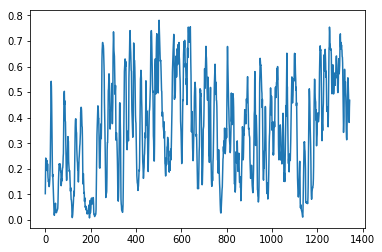

In [104]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

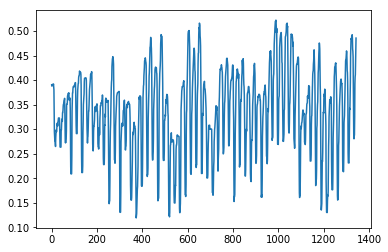

In [105]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [106]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the Recurrent Neural Network¶

In [115]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))


In [116]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean


In [119]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         792576    
_________________________________________________________________
dense (Dense)                (None, None, 1)           513       
Total params: 793,089
Trainable params: 793,089
Non-trainable params: 0
_________________________________________________________________


In [133]:
path_checkpoint = '~/0MyDataBases/40Python/J_inertia/23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

NAME = "inertia-{}".format(int(time.time()))
callback_tensorboard = TensorBoard(log_dir='23_logs/{}'.format(NAME),
                                   histogram_freq=0,
                                   write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [134]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
 99/100 [============================>.] - ETA: 4:54 - loss: 0.003 - ETA: 4:49 - loss: 0.003 - ETA: 4:46 - loss: 0.003 - ETA: 4:42 - loss: 0.003 - ETA: 4:40 - loss: 0.002 - ETA: 4:36 - loss: 0.002 - ETA: 4:33 - loss: 0.002 - ETA: 4:30 - loss: 0.002 - ETA: 4:27 - loss: 0.002 - ETA: 4:24 - loss: 0.002 - ETA: 4:21 - loss: 0.003 - ETA: 4:18 - loss: 0.002 - ETA: 4:15 - loss: 0.002 - ETA: 4:12 - loss: 0.002 - ETA: 4:09 - loss: 0.003 - ETA: 4:06 - loss: 0.003 - ETA: 4:03 - loss: 0.003 - ETA: 4:00 - loss: 0.003 - ETA: 3:57 - loss: 0.002 - ETA: 3:54 - loss: 0.002 - ETA: 3:51 - loss: 0.003 - ETA: 3:48 - loss: 0.002 - ETA: 3:45 - loss: 0.002 - ETA: 3:42 - loss: 0.002 - ETA: 3:39 - loss: 0.003 - ETA: 3:36 - loss: 0.003 - ETA: 3:33 - loss: 0.003 - ETA: 3:30 - loss: 0.003 - ETA: 3:28 - loss: 0.003 - ETA: 3:25 - loss: 0.003 - ETA: 3:22 - loss: 0.003 - ETA: 3:19 - loss: 0.003 - ETA: 3:16 - loss: 0.003 - ETA: 3:13 - loss: 0.002 - ETA: 3:10 - loss: 0.002 - ETA: 3:07 - loss: 0.002 - ETA: 3:04 

 99/100 [============================>.] - ETA: 4:49 - loss: 0.002 - ETA: 4:46 - loss: 0.002 - ETA: 4:42 - loss: 0.002 - ETA: 4:40 - loss: 0.002 - ETA: 4:37 - loss: 0.002 - ETA: 4:33 - loss: 0.002 - ETA: 4:30 - loss: 0.002 - ETA: 4:27 - loss: 0.002 - ETA: 4:25 - loss: 0.002 - ETA: 4:22 - loss: 0.002 - ETA: 4:19 - loss: 0.002 - ETA: 4:16 - loss: 0.002 - ETA: 4:13 - loss: 0.002 - ETA: 4:10 - loss: 0.002 - ETA: 4:07 - loss: 0.002 - ETA: 4:04 - loss: 0.002 - ETA: 4:01 - loss: 0.002 - ETA: 3:58 - loss: 0.002 - ETA: 3:55 - loss: 0.002 - ETA: 3:52 - loss: 0.002 - ETA: 3:50 - loss: 0.002 - ETA: 3:47 - loss: 0.002 - ETA: 3:44 - loss: 0.002 - ETA: 3:41 - loss: 0.002 - ETA: 3:38 - loss: 0.002 - ETA: 3:35 - loss: 0.002 - ETA: 3:32 - loss: 0.002 - ETA: 3:29 - loss: 0.002 - ETA: 3:26 - loss: 0.002 - ETA: 3:23 - loss: 0.002 - ETA: 3:21 - loss: 0.002 - ETA: 3:18 - loss: 0.002 - ETA: 3:15 - loss: 0.002 - ETA: 3:12 - loss: 0.002 - ETA: 3:09 - loss: 0.002 - ETA: 3:06 - loss: 0.002 - ETA: 3:03 - loss: 0.0

Epoch 00005: val_loss improved from 0.00275 to 0.00271, saving model to ~/0MyDataBases/40Python/J_inertia/23_checkpoint.keras
100/100 [==============================] - 294s 3s/step - loss: 0.0018 - val_loss: 0.0027
Epoch 6/20
 99/100 [============================>.] - ETA: 4:47 - loss: 0.001 - ETA: 4:45 - loss: 0.001 - ETA: 4:42 - loss: 0.001 - ETA: 4:40 - loss: 0.001 - ETA: 4:37 - loss: 0.001 - ETA: 4:34 - loss: 0.001 - ETA: 4:30 - loss: 0.001 - ETA: 4:28 - loss: 0.001 - ETA: 4:25 - loss: 0.001 - ETA: 4:22 - loss: 0.001 - ETA: 4:19 - loss: 0.001 - ETA: 4:16 - loss: 0.001 - ETA: 4:13 - loss: 0.001 - ETA: 4:10 - loss: 0.001 - ETA: 4:07 - loss: 0.001 - ETA: 4:05 - loss: 0.001 - ETA: 4:02 - loss: 0.001 - ETA: 3:59 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:53 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:47 - loss: 0.001 - ETA: 3:44 - loss: 0.001 - ETA: 3:41 - loss: 0.001 - ETA: 3:38 - loss: 0.001 - ETA: 3:35 - loss: 0.001 - ETA: 3:32 - loss: 0.001 - ETA: 3:29 - loss: 0.001 - ET

 99/100 [============================>.] - ETA: 4:47 - loss: 0.001 - ETA: 4:46 - loss: 0.001 - ETA: 4:42 - loss: 0.001 - ETA: 4:39 - loss: 0.001 - ETA: 4:37 - loss: 0.001 - ETA: 4:34 - loss: 0.001 - ETA: 4:31 - loss: 0.001 - ETA: 4:28 - loss: 0.001 - ETA: 4:25 - loss: 0.001 - ETA: 4:22 - loss: 0.001 - ETA: 4:19 - loss: 0.001 - ETA: 4:17 - loss: 0.001 - ETA: 4:14 - loss: 0.001 - ETA: 4:11 - loss: 0.001 - ETA: 4:08 - loss: 0.001 - ETA: 4:05 - loss: 0.001 - ETA: 4:02 - loss: 0.001 - ETA: 3:59 - loss: 0.001 - ETA: 3:56 - loss: 0.001 - ETA: 3:53 - loss: 0.001 - ETA: 3:50 - loss: 0.001 - ETA: 3:47 - loss: 0.001 - ETA: 3:44 - loss: 0.001 - ETA: 3:41 - loss: 0.001 - ETA: 3:38 - loss: 0.001 - ETA: 3:35 - loss: 0.001 - ETA: 3:33 - loss: 0.001 - ETA: 3:30 - loss: 0.001 - ETA: 3:27 - loss: 0.001 - ETA: 3:24 - loss: 0.001 - ETA: 3:21 - loss: 0.001 - ETA: 3:18 - loss: 0.001 - ETA: 3:15 - loss: 0.001 - ETA: 3:12 - loss: 0.001 - ETA: 3:09 - loss: 0.001 - ETA: 3:06 - loss: 0.001 - ETA: 3:03 - loss: 0.0

100/100 [==============================] - 294s 3s/step - loss: 0.0017 - val_loss: 0.0028
Epoch 11/20
 99/100 [============================>.] - ETA: 4:48 - loss: 0.001 - ETA: 4:46 - loss: 0.001 - ETA: 4:42 - loss: 0.001 - ETA: 4:39 - loss: 0.001 - ETA: 4:36 - loss: 0.001 - ETA: 4:33 - loss: 0.001 - ETA: 4:31 - loss: 0.001 - ETA: 4:28 - loss: 0.001 - ETA: 4:25 - loss: 0.001 - ETA: 4:22 - loss: 0.001 - ETA: 4:19 - loss: 0.001 - ETA: 4:16 - loss: 0.001 - ETA: 4:13 - loss: 0.001 - ETA: 4:10 - loss: 0.001 - ETA: 4:07 - loss: 0.001 - ETA: 4:04 - loss: 0.001 - ETA: 4:01 - loss: 0.001 - ETA: 3:58 - loss: 0.001 - ETA: 3:55 - loss: 0.001 - ETA: 3:52 - loss: 0.001 - ETA: 3:49 - loss: 0.001 - ETA: 3:47 - loss: 0.001 - ETA: 3:44 - loss: 0.001 - ETA: 3:41 - loss: 0.001 - ETA: 3:38 - loss: 0.001 - ETA: 3:35 - loss: 0.001 - ETA: 3:32 - loss: 0.001 - ETA: 3:29 - loss: 0.001 - ETA: 3:26 - loss: 0.001 - ETA: 3:23 - loss: 0.001 - ETA: 3:20 - loss: 0.001 - ETA: 3:18 - loss: 0.001 - ETA: 3:15 - loss: 0.001

KeyboardInterrupt: 

In [168]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))    

1/1 [==============================] - 2s 2s/step


In [169]:

print("loss (test-set):", result)


loss (test-set): 0.0025864928029477596


In [203]:
#predicting 
x = x_test_scaled
x = np.expand_dims(x, axis=0)

p=model.predict(x)
p_scaled=y_scaler.inverse_transform(p[0])

In [205]:
predict['predict_dnn']=p_scaled.reshape(p.shape[1])
predict.head()

,Time,Inertia,predict_dnn
utime,,,
1451606400,2016-01-01 00:00:00,248023.9375,242024.046875
1451610000,2016-01-01 01:00:00,241079.3594,226205.406250
1451613600,2016-01-01 02:00:00,235510.2031,224556.578125
1451617200,2016-01-01 03:00:00,235510.2031,222934.500000
1451620800,2016-01-01 04:00:00,235374.2031,223327.968750


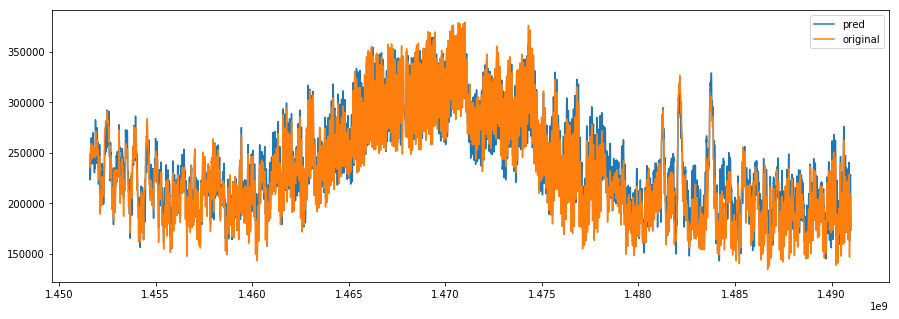

In [206]:
plt.figure(figsize=(15,5))
        
# Plot and compare the two signals.
plt.plot(predict['predict_dnn'], label='pred')
plt.plot(predict['Inertia'], label='original')

# Plot labels etc.

plt.legend()
plt.show()

In [213]:


inertia = go.Scatter(
    x = predict['Time'],
    y = predict['Inertia'],
    name='original inertia'
)

prediction_dnn = go.Scatter(
    x = predict['Time'],
    y = predict['predict_dnn'],
    name='prediction_dnn'
)

error_dnn = go.Scatter(
    x = predict['Time'],
    y = predict['Inertia']- predict['predict_dnn'],
    name='error_dnn'
)


data = [inertia,prediction_dnn,error_dnn]

# Create layout for plotly
layout = dict(
    title='Predictions',
    xaxis1=dict(title='', rangeslider=dict(thickness=0.015, borderwidth=1), type='date', showgrid=True),
    # updatemenus=list([
    #     dict(
    #         buttons=[vis_dict for vis_dict in l_vis_dicts],
    #         type='buttons',
    #         active=0,
    #     )])
            )

# layout.update(d_axis_domains)  # Update layout with yaxis# keys

# Plot with plotly
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename='bla')

import plotly.plotly as py
# plotly.tools.set_credentials_file(username='mnorayr@gmail.com', api_key='Ajl8YWnoal9xNmvgDuMe')
py.iplot(fig, filename='bla')



/home/norayr/.conda/envs/keras/lib/python3.6/site-packages/plotly/offline/offline.py:607: UserWarning:

Your filename `bla` didn't end with .html. Adding .html to the end of your file.

/home/norayr/.conda/envs/keras/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

